| Names             | IDs      |
|-------------------|----------|
| yahia ashraf      | 20200636 |
| yahia mahmoud     | 20201222 |
| hamza abdel hamid | 20200162 |
| ziad ibrahim      | 20200193 |
| omar tarek        | 20200348 |

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import layers, Sequential
from scikeras.wrappers import KerasClassifier
from matplotlib import pyplot
import spacy
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

In [ ]:
df = pd.read_csv("sentimentdataset (Project 1).csv")
df

,Source,ID,Message,Target
0,Yelp,0,Crust is not good.,0
1,Yelp,1,Not tasty and the texture was just nasty.,0
2,Yelp,2,Stopped by during the late May bank holiday of...,1
3,Yelp,3,The selection on the menu was great and so wer...,1
4,Yelp,4,Now I am getting angry and I want my damn pho.,0
...,...,...,...,...
2740,Amazon,994,The screen does get smudged easily because it ...,0
2741,Amazon,995,What a piece of junk.. I lose more calls on th...,0
2742,Amazon,996,Item Does Not Match Picture.,0
2743,Amazon,997,The only thing that disappoint me is the infra...,0


#Exploratory Data Analysis

In [ ]:
source_counts = df['Source'].value_counts()
target_counts = df['Target'].value_counts()

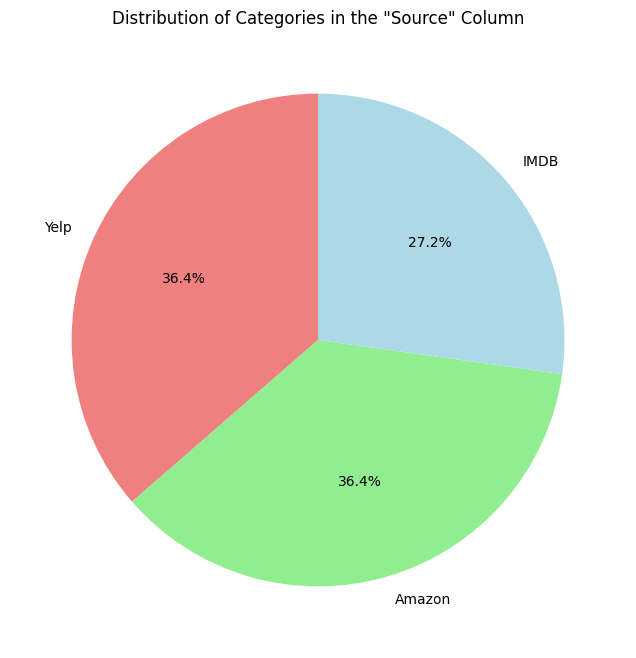

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen', 'lightblue'])
plt.title('Distribution of Categories in the "Source" Column')
plt.show()

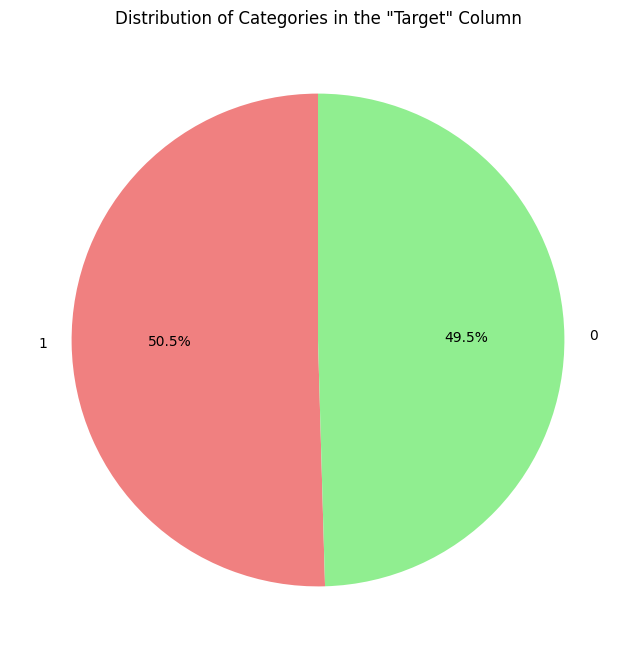

In [ ]:
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen', 'lightblue'])
plt.title('Distribution of Categories in the "Target" Column')
plt.show()

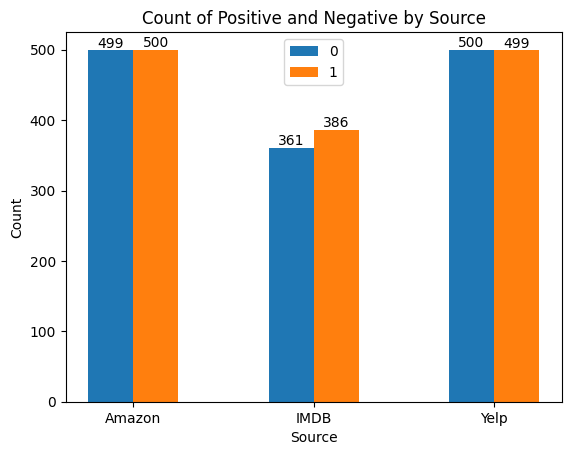

In [ ]:
# Group by 'source' and 'target' and get the count
grouped_data = df.groupby(['Source', 'Target']).size().unstack()

# Plotting the bar chart
fig, ax = plt.subplots()
width = 0.25  # the width of the bars

sources = grouped_data.index
ind = range(len(sources))

bar_0 = ax.bar(ind, grouped_data[0], width, label='0')
bar_1 = ax.bar([i + width for i in ind], grouped_data[1], width, label='1')

# Adding labels and title
ax.set_xlabel('Source')
ax.set_ylabel('Count')
ax.set_title('Count of Positive and Negative by Source')
ax.set_xticks([i + width/2 for i in ind])
ax.set_xticklabels(sources)
ax.legend()

for bar in bar_0:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bar_1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

#Preproccessing

In [ ]:
nlp = spacy.load('en_core_web_sm')
# Add 'not' to spaCy stop words
spacy_stop_words = spacy.lang.en.stop_words.STOP_WORDS

# add others
words_to_keep = ["not", "no", "never", "but", "only", "against",
    "don't", "doesn't", "didn't", "isn't", "aren't", "wasn't", "weren't",
    "hasn't", "haven't", "hadn't", "won't", "wouldn't", "can't", "cannot",
    "could've", "should've", "would've", "doesn't", "didn't", "isn't", "ain't"]

for word in words_to_keep:
    spacy_stop_words.discard(word)

# Function for lemmatization and removing stop words
def lemmatize_and_remove_stop_words(text):
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc if token.text.lower() not in spacy_stop_words]
    return ' '.join(lemmatized_text)

df = pd.read_csv("sentimentdataset (Project 1).csv")

df.drop(columns = ['Source', 'ID'], inplace=True)

# Apply the function to the "Message" column
df['Message'] = df['Message'].apply(lemmatize_and_remove_stop_words)

print(df['Message'])

# Save the updated DataFrame to a new CSV file
df.to_csv('sentimentdataset_stopwords_lemmatized.csv', index=False)

0                                        crust not good .
1                               not tasty texture nasty .
2       stop late bank holiday Rick Steve recommendati...
3                            selection menu great price .
4                               get angry want damn pho .
                              ...                        
2740                screen smudge easily touch ear face .
2741                      piece junk .. lose call phone .
2742                             item not match Picture .
2743      only thing disappoint infra red port ( irda ) .
2744                  not answer call unit , never work !
Name: Message, Length: 2745, dtype: object


In [ ]:
# read the preprocessed file
df = pd.read_csv("sentimentdataset_stopwords_lemmatized.csv")
df

,Message,Target
0,crust not good .,0
1,not tasty texture nasty .,0
2,stop late bank holiday Rick Steve recommendati...,1
3,selection menu great price .,1
4,get angry want damn pho .,0
...,...,...
2740,screen smudge easily touch ear face .,0
2741,piece junk .. lose call phone .,0
2742,item not match Picture .,0
2743,only thing disappoint infra red port ( irda ) .,0


In [ ]:
X = df['Message']
y = df['Target']

In [ ]:
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer()

# Transform the training and testing data
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#SVC Model

In [ ]:
# to convert it to a data frame
# df_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

svc = LinearSVC(max_iter=100000, dual=False)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'loss': ['squared_hinge'],
    'tol': [1e-3, 1e-2, 1e-1, 1],
    'class_weight': [None, 'balanced']
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, scoring='accuracy', error_score='raise', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=LinearSVC(dual=False, max_iter=100000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'loss': ['squared_hinge'], 'penalty': ['l1', 'l2'],
                         'tol': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [ ]:
# Print the best parameters found by grid search
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2', 'tol': 0.01}


In [ ]:
# Predict on the testing set with the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Testing Set: {:.2f}%".format(accuracy * 100))

Accuracy on Testing Set: 83.79%


In [ ]:
# Display additional metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       265
           1       0.87      0.81      0.84       284

    accuracy                           0.84       549
   macro avg       0.84      0.84      0.84       549
weighted avg       0.84      0.84      0.84       549



#ANN Model

In [ ]:
def build_model(neurons=16, learning_rate=0.01):
  model = Sequential()
  model.add(layers.Dense(units=neurons, activation='relu', input_dim=X_train.shape[1]))
  model.add(layers.Dense(units=neurons, activation='relu'))
  model.add(layers.Dense(units=1, activation='sigmoid'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(build_fn=build_model,neurons = [16, 32, 64, 128], learning_rate = [0.001, 0.01, 0.1], batch_size=[16, 32, 64], verbose=0)

print(model.get_params().keys())
param_grid = {
    'neurons': [16, 32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64, 128]
}


dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs', 'neurons', 'learning_rate', 'class_weight'])


In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

In [ ]:
print("Best: ANN model is %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: ANN model is 0.791439 using {'batch_size': 16, 'learning_rate': 0.01, 'neurons': 16}


In [ ]:
best_model = grid_result.best_estimator_
best_model.fit(X_train, y_train)
prediction = best_model.predict(X_test)
acc = accuracy_score(y_pred=prediction, y_true=y_test)
print(f'Test Accuracy: {acc}')

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Test Accuracy: 0.8415300546448088


In [ ]:
report = classification_report(y_test, prediction)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       265
           1       0.84      0.85      0.85       284

    accuracy                           0.84       549
   macro avg       0.84      0.84      0.84       549
weighted avg       0.84      0.84      0.84       549

